In [1]:
import numpy as np
import pandas as pd
import uproot
import re

import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

## function reading Honda *.d file

### 1) Read the *.d files

In [2]:
def read_honda_flux(path):
    """
    Read a Honda atmospheric neutrino flux .d file and return a tidy DataFrame.

    Returns columns:
      Enu_GeV, NuMu, NuMubar, NuE, NuEbar,
      cosz_low, cosz_high, phi_low, phi_high
    """
    # Header example:
    # average flux in [cosZ = 0.90 --  1.00  phi_Az =   0 --  30]
    hdr_re = re.compile(
        r"cosZ\s*=\s*([-\d.]+)\s*--\s*([-\d.]+).*?"
        r"phi_Az\s*=\s*([-\d.]+)\s*--\s*([-\d.]+)",
        re.IGNORECASE,
    )

    # Numeric line starts with scientific-notation energy
    numline_re = re.compile(r"^\s*[-+]?\d+\.\d+E[-+]\d+")

    blocks = []
    cur_meta = None
    cur_rows = []

    with open(path, "r") as f:
        for line in f:
            line = line.rstrip("\n")

            # New block
            if line.lower().startswith("average flux"):
                if cur_meta is not None and cur_rows:
                    blocks.append((cur_meta, cur_rows))
                cur_rows = []

                m = hdr_re.search(line)
                if not m:
                    raise ValueError(f"Could not parse header line:\n{line}")

                cosz_low, cosz_high, phi_low, phi_high = map(float, m.groups())
                cur_meta = dict(
                    cosz_low=cosz_low,
                    cosz_high=cosz_high,
                    phi_low=phi_low,
                    phi_high=phi_high,
                )
                continue

            # Skip column header line
            if "Enu" in line and "NuMu" in line:
                continue

            # Keep numeric data lines only
            if numline_re.match(line):
                parts = line.split()
                if len(parts) < 5:
                    continue
                cur_rows.append([float(x) for x in parts[:5]])

    # Flush final block
    if cur_meta is not None and cur_rows:
        blocks.append((cur_meta, cur_rows))

    # Assemble DataFrame
    dfs = []
    for meta, rows in blocks:
        arr = np.asarray(rows, dtype=float)
        dfb = pd.DataFrame(
            arr,
            columns=["Enu_GeV", "NuMu", "NuMubar", "NuE", "NuEbar"],
        )
        for k, v in meta.items():
            dfb[k] = v
        dfs.append(dfb)

    if not dfs:
        raise RuntimeError(f"No flux blocks found in {path}")

    return pd.concat(dfs, ignore_index=True)


In [3]:
## the flux files are downloaded from http://www-rccn.icrr.u-tokyo.ac.jp/mhonda/public/nflx2014/index.html
ang_avg_homestake_solar_max = read_honda_flux("/Users/sungbino/OneDrive/OneDrive/SBND/sbnd_dune_phase_space/flux/atm/Honda/hms-ally-01-01-solmax.d")
ang_avg_homestake_solar_min = read_honda_flux("/Users/sungbino/OneDrive/OneDrive/SBND/sbnd_dune_phase_space/flux/atm/Honda/hms-ally-01-01-solmin.d")

In [4]:
ang_avg_homestake_solar_max

,Enu_GeV,NuMu,NuMubar,NuE,NuEbar,cosz_low,cosz_high,phi_low,phi_high
0,0.10000,1.412800e+04,1.434400e+04,6.855500e+03,6.565900e+03,-1.0,1.0,0.0,360.0
1,0.11220,1.214100e+04,1.228200e+04,5.956200e+03,5.654100e+03,-1.0,1.0,0.0,360.0
2,0.12589,1.038600e+04,1.047300e+04,5.116900e+03,4.813800e+03,-1.0,1.0,0.0,360.0
3,0.14125,8.829400e+03,8.873300e+03,4.356000e+03,4.054400e+03,-1.0,1.0,0.0,360.0
4,0.15849,7.437800e+03,7.450500e+03,3.679900e+03,3.384100e+03,-1.0,1.0,0.0,360.0
...,...,...,...,...,...,...,...,...,...
96,6309.60000,5.608200e-10,3.205900e-10,1.824700e-11,1.320400e-11,-1.0,1.0,0.0,360.0
97,7079.50000,3.755000e-10,2.133900e-10,1.198500e-11,8.679800e-12,-1.0,1.0,0.0,360.0
98,7943.30000,2.508900e-10,1.416400e-10,7.859100e-12,5.686400e-12,-1.0,1.0,0.0,360.0
99,8912.50000,1.672300e-10,9.375000e-11,5.179000e-12,3.718000e-12,-1.0,1.0,0.0,360.0


In [5]:
ang_avg_homestake_solar_min

,Enu_GeV,NuMu,NuMubar,NuE,NuEbar,cosz_low,cosz_high,phi_low,phi_high
0,0.10000,1.667600e+04,1.691500e+04,8.218600e+03,7.609500e+03,-1.0,1.0,0.0,360.0
1,0.11220,1.427300e+04,1.443200e+04,7.117400e+03,6.532700e+03,-1.0,1.0,0.0,360.0
2,0.12589,1.216200e+04,1.225900e+04,6.091300e+03,5.542700e+03,-1.0,1.0,0.0,360.0
3,0.14125,1.029600e+04,1.034300e+04,5.162800e+03,4.650600e+03,-1.0,1.0,0.0,360.0
4,0.15849,8.633900e+03,8.645800e+03,4.341100e+03,3.865900e+03,-1.0,1.0,0.0,360.0
...,...,...,...,...,...,...,...,...,...
96,6309.60000,5.608200e-10,3.205900e-10,1.824700e-11,1.320400e-11,-1.0,1.0,0.0,360.0
97,7079.50000,3.755000e-10,2.133900e-10,1.198500e-11,8.679800e-12,-1.0,1.0,0.0,360.0
98,7943.30000,2.508900e-10,1.416400e-10,7.859100e-12,5.686400e-12,-1.0,1.0,0.0,360.0
99,8912.50000,1.672300e-10,9.375000e-11,5.179000e-12,3.718000e-12,-1.0,1.0,0.0,360.0


### 2) Make splins for the flux to produce flux arrays with linear E_nu spacing

In [6]:
def make_flux_array(flux_df):
    Enu = flux_df.Enu_GeV
    numu_flux = flux_df.NuMu
    numubar_flux = flux_df.NuMubar
    nue_flux = flux_df.NuE
    nuebar_flux = flux_df.NuEbar

    numu_spline = CubicSpline(Enu, numu_flux)
    numubar_spline = CubicSpline(Enu, numubar_flux)
    nue_spline = CubicSpline(Enu, nue_flux)
    nuebar_spline = CubicSpline(Enu, nuebar_flux)

    ## make linear space flux arrays from 0.1 GeV to 20 GeV
    N_bins = 9950 ## this is for 0.002 GeV bin width
    Enu_lin = np.linspace(0.1 + (20. - 0.1) / (2.*N_bins), 20 + (20. -0.1) / (2. * N_bins), N_bins + 1) ## shifting by half bin width to get bin center values
    numu_flux_lin = numu_spline(Enu_lin)
    numubar_flux_lin = numubar_spline(Enu_lin)
    nue_flux_lin = nue_spline(Enu_lin)
    nuebar_flux_lin = nuebar_spline(Enu_lin)

    # return the linear space arrays
    return Enu_lin, numu_flux_lin, numubar_flux_lin, nue_flux_lin, nuebar_flux_lin

In [7]:
flux_arr_solar_max = make_flux_array(ang_avg_homestake_solar_max)
flux_arr_solar_min = make_flux_array(ang_avg_homestake_solar_min)

### 3) Plot the linear flux arrays

In [8]:
def plot_E_nu_vs_flux(flux_arr, title):
    Enu_lin, numu_flux_lin, numubar_flux_lin, nue_flux_lin, nuebar_flux_lin = flux_arr

    plt.figure(figsize=(10, 6))
    plt.plot(Enu_lin, numu_flux_lin, label='NuMu Flux', color='blue')
    plt.plot(Enu_lin, numubar_flux_lin, label='NuMubar Flux', color='red')
    plt.plot(Enu_lin, nue_flux_lin, label='NuE Flux', color='green')
    plt.plot(Enu_lin, nuebar_flux_lin, label='NuEbar Flux', color='orange')

    plt.yscale('log')
    plt.xlabel('Neutrino Energy (GeV)')
    plt.ylabel('Flux (units)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

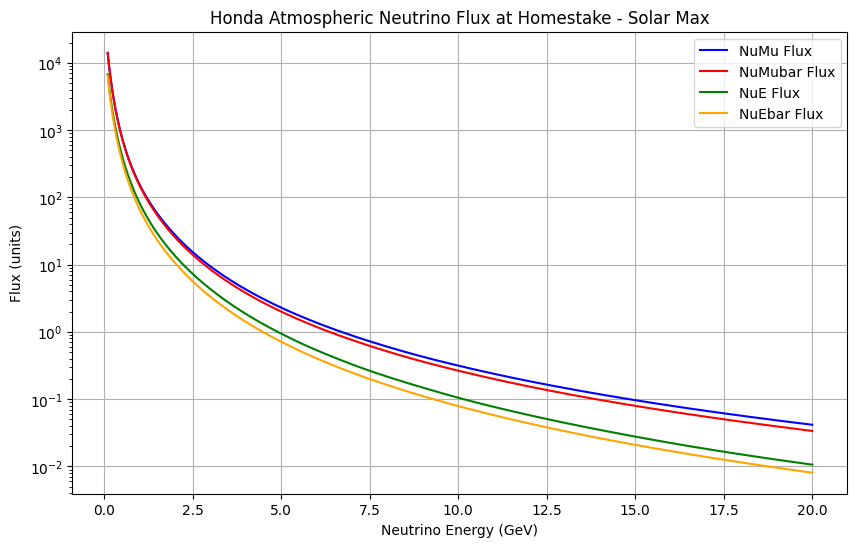

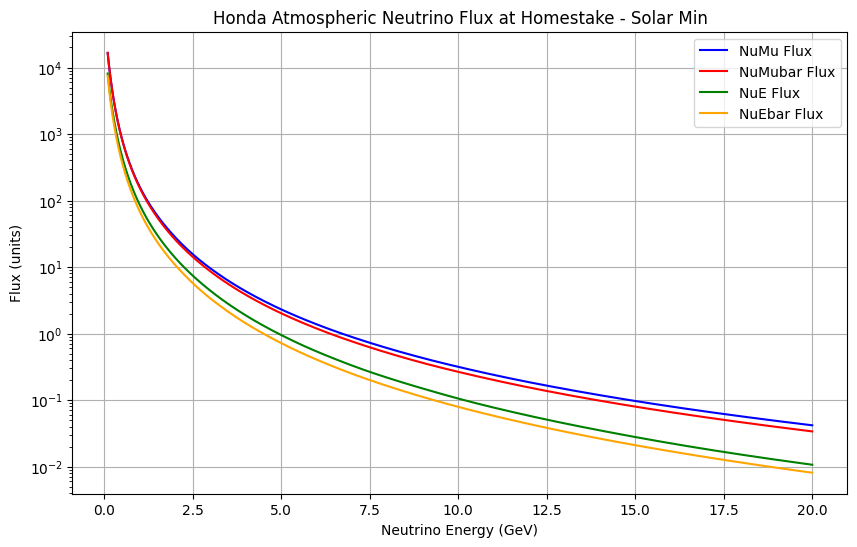

In [9]:
plot_E_nu_vs_flux(flux_arr_solar_max, "Honda Atmospheric Neutrino Flux at Homestake - Solar Max")
plot_E_nu_vs_flux(flux_arr_solar_min, "Honda Atmospheric Neutrino Flux at Homestake - Solar Min")

### 4) Save the flux into ROOT file as TH1D

In [10]:
def save_flux_to_root(flux_data, filename="honda_homestake_solar_max.root"):
    # centers is index 0 (length 200)
    centers = np.array(flux_data[0])
    flavors = ["numu", "numubar", "nue", "nuebar"]
    
    # 1. Calculate the uniform bin width
    # In uniform binning, any two adjacent centers give the width
    bin_width = centers[1] - centers[0]
    
    # 2. Create the edges array (length 201)
    # The first edge is half a width below the first center
    start_edge = centers[0] - (bin_width / 2.0)
    # The last edge is half a width above the last center
    end_edge = centers[-1] + (bin_width / 2.0)
    
    # Generate 201 evenly spaced edges from start to end
    edges = np.linspace(start_edge, end_edge, len(centers) + 1)

    with uproot.recreate(filename) as f:
        for i, name in enumerate(flavors, start=1):
            flux_values = np.array(flux_data[i])
            
            # Write as TH1D: (counts, edges)
            f[name] = (flux_values, edges)
            
    print(f"File '{filename}' created successfully.")
    print(f"Bin width: {bin_width:.4f}, Range: [{edges[0]:.2f}, {edges[-1]:.2f}]")

In [11]:
save_flux_to_root(flux_arr_solar_max, filename="honda_homestake_solar_max_linear.root")
save_flux_to_root(flux_arr_solar_min, filename="honda_homestake_solar_min_linear.root")

File 'honda_homestake_solar_max_linear.root' created successfully.
Bin width: 0.0020, Range: [0.10, 20.00]
File 'honda_homestake_solar_min_linear.root' created successfully.
Bin width: 0.0020, Range: [0.10, 20.00]
